In [1]:
%load_ext autoreload
%autoreload 2

from mair_tools import notebook_utils
import pandas as pd
import matplotlib
import pickle
import re
import os
import spacy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy.lang.en
from collections import Counter
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from gensim.models import CoherenceModel
from gensim import corpora
from gensim import models
import gensim.summarization
from pprint import pprint

from gensim.models import ldamodel

sns.set_theme()

PICKLED_PATH = "parserd_pdfs.pkl"

In [2]:
if not os.path.exists(PICKLED_PATH):
    pdfs = notebook_utils.parse_all_files_from_path("../articles/FAT_20/")
    with open(PICKLED_PATH, "wb+") as f:
        pickle.dump(pdfs, f)
else:
    with open(PICKLED_PATH, "rb") as f:
        pdfs = pickle.load(f)

# Cleaning

In [3]:
df = pd.DataFrame(pdfs)
df['pages_num']=df.pages.str.len()

<AxesSubplot:>

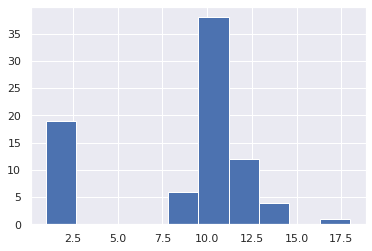

In [4]:
df.pages_num.hist()

### Removing papers with only one page

<AxesSubplot:>

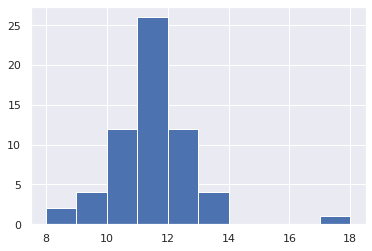

In [5]:
df=df[df.pages_num!=1]
df.pages_num.hist()

### Removing references and bibliography

In [6]:
def clean_text(text):
    # removing bibliography
    position = text.lower().rfind("references")
    text = text[:position]

    text = text.replace("\n", " ")  # removing newlines

    text = re.sub("\[[^\[^\]]*\]", "", text)  # removing references
    return text

In [7]:
df['cleaned_text']=df.full_text.apply(clean_text)

# Keywords

In [8]:
en=spacy.load('en_core_web_lg')

In [9]:
en = spacy.lang.en.English()

In [10]:
tokenized = df.cleaned_text.apply(lambda x: en(x))

In [11]:
lemmas = tokenized.apply(
    lambda doc: 
        [word.lemma_.lower() for word in doc if not word.is_stop if word.is_alpha])

In [12]:
all_lemas = []
for l in lemmas:
    all_lemas+=l

In [13]:
unigrams = nltk.FreqDist(all_lemas)

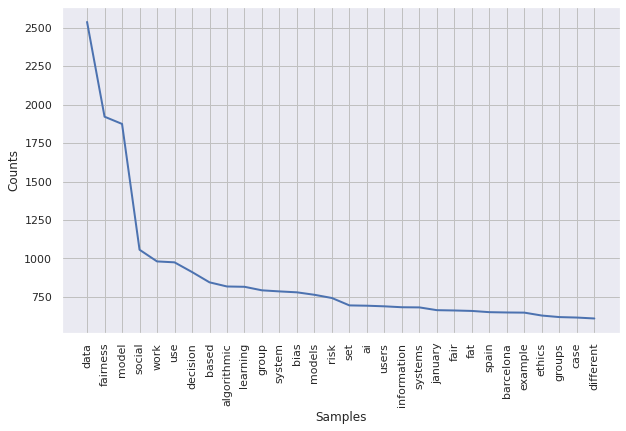

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [14]:
plt.figure(figsize=(10,6))

unigrams.plot(30)

## TFIDF

In [16]:
dictionary = corpora.Dictionary(lemmas)

In [17]:
bow_lemmas = lemmas.apply(dictionary.doc2bow)

In [18]:
tfidf = models.TfidfModel(list(bow_lemmas))

In [19]:
from gensim import similarities

index = similarities.SparseMatrixSimilarity(tfidf[bow_lemmas], num_features=12)

#TODO

## Keywords

In [21]:
keywords = lemmas.apply(" ".join).apply(gensim.summarization.keywords).str.split('\n')

keywords

In [23]:
all_keywords = []
for k in keywords:
    all_keywords+=k

nltk.FreqDist(all_keywords).plot(20)

## LDA

In [38]:
lda = ldamodel.LdaModel(list(bow_lemmas), num_topics=5, id2word=dictionary)

pprint(lda.print_topics())

In [55]:
coherence_model_lda = CoherenceModel(model=lda, texts=list(lemmas), dictionary=dictionary, coherence='c_v')

coherence_model_lda.get_coherence()

In [62]:
grid = list(ParameterGrid({
    "num_topics": [2, 3, 4, 5, 6, 7, 8, 9],
    "alpha": list(np.arange(0.01, 1, 0.3)) + ["auto", "asymmetric"],
}))

models = []
scores = []

for params in tqdm(grid):
    lda_model = ldamodel.LdaModel(list(bow_lemmas),id2word=dictionary,**params)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=list(lemmas), dictionary=dictionary, coherence='c_v')
    scores.append(coherence_model_lda.get_coherence())
    models.append(lda_model)

In [70]:
best_id = np.argmax(scores)

In [71]:
scores[best_id]

0.30516331347081993

In [72]:
models[best_id]

In [73]:
models[best_id].print_topics()

[(0,
  '0.010*"data" + 0.005*"fairness" + 0.005*"model" + 0.004*"ethics" + 0.004*"based" + 0.004*"social" + 0.003*"users" + 0.003*"system" + 0.003*"use" + 0.003*"algorithmic"'),
 (1,
  '0.010*"data" + 0.007*"model" + 0.006*"fairness" + 0.004*"bias" + 0.004*"social" + 0.004*"based" + 0.003*"use" + 0.003*"decision" + 0.003*"group" + 0.003*"work"'),
 (2,
  '0.007*"model" + 0.005*"data" + 0.004*"work" + 0.004*"decision" + 0.004*"use" + 0.004*"fairness" + 0.003*"social" + 0.003*"set" + 0.003*"group" + 0.003*"users"'),
 (3,
  '0.010*"data" + 0.008*"fairness" + 0.006*"model" + 0.005*"algorithmic" + 0.004*"work" + 0.004*"social" + 0.004*"use" + 0.003*"learning" + 0.003*"system" + 0.003*"information"'),
 (4,
  '0.010*"data" + 0.006*"model" + 0.005*"ethics" + 0.004*"work" + 0.004*"fairness" + 0.004*"learning" + 0.004*"social" + 0.003*"use" + 0.003*"models" + 0.003*"risk"'),
 (5,
  '0.009*"fairness" + 0.009*"data" + 0.005*"model" + 0.004*"social" + 0.004*"group" + 0.004*"decision" + 0.004*"system